## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

**QUESTION:** Load dataset and display some lines of the csv file.

In [26]:
data = pd.read_csv("ai4i2020.csv")
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


We can see that the input data are :
- UDI
- Product ID
- Product type
- Air temperature
- Process temperature
- Rotational speed
- Torque
- Tool wear
- Machine failure

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

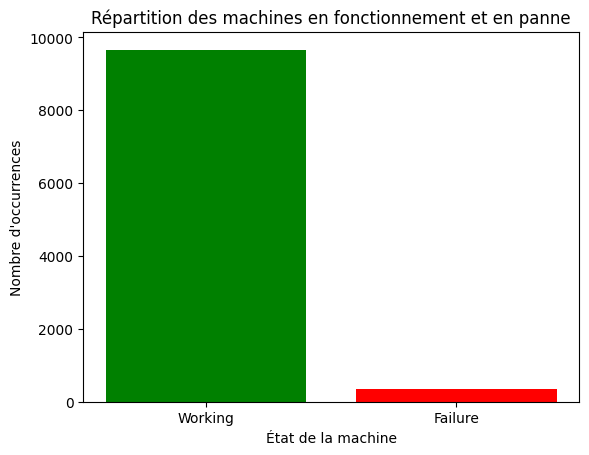

Nombre d'occurrences de chaque état :
 Machine failure
0    9661
1     339
Name: count, dtype: int64
Pourcentage de machines en panne : 3.39%


In [27]:
counts_failure = data['Machine failure'].value_counts()

plt.bar(counts_failure.index, counts_failure.values, color=["green", "red"])

plt.xticks([0, 1], ["Working", "Failure"])  # Noms des états
plt.xlabel("État de la machine")
plt.ylabel("Nombre d'occurrences")
plt.title("Répartition des machines en fonctionnement et en panne")

plt.show()
print("Nombre d'occurrences de chaque état :\n", counts_failure)

print("Pourcentage de machines en panne : {:.2f}%".format(counts_failure[1] / counts_failure.sum() * 100))

**ANALYSIS QUESTION:** What do you observe?


Lorsque nous affichons les données nous mettons les RNF dans la colonne Working. En effet lorsqu'un RNF a lieu cela n'est pas répertorié comme une 'Machine Failure'. On les retrouve donc dans la colonne Working ce qui est cohérent puisque ces problèmes sont aléatoires et que l'objectif de notre modèle est de prévoir les problèmes sur les machines. Nous ne pouvons pas prévoir les problèmes aléatoires, il est donc cohérent que nous ne comptabilisions pas ces Fail aléatoires comme des Fails puisque nous ne souhaitons pas les prendre en compte dans l'apprentissage.

Au final nous voyons que nous avons peu de données pour les Failure (uniquement 339 sur 10 000 données au total). Cela va donc compliquer l'apprentissage.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Nous avons peu de données répertoriant des Fails dans notre Dataset. Notre objectif est d'identifier les pannes sur la machine et nous avons seulement 339 réferencements de pannes. Ainsi, même si notre Dataset est de grande taille il n'est pas très complet car 96,61% (1 - 339/10000) des données correspondent à un fonctionnement normal.

Notre apprentissage risque donc d'être peu précis à cause d'une faible quantité de données.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

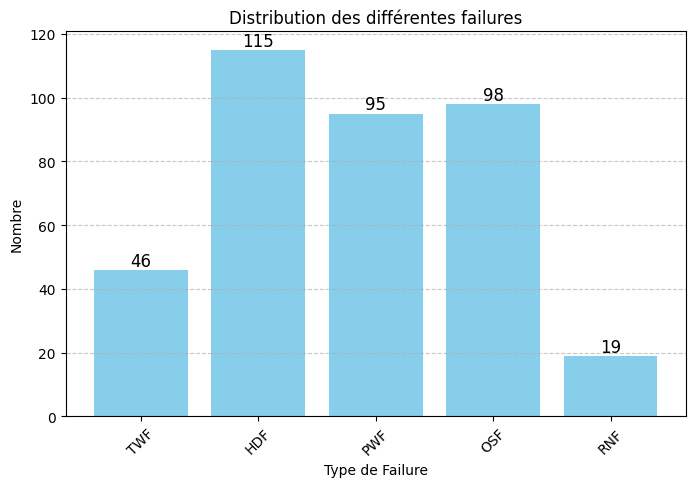

In [28]:
dataset = pd.read_csv("ai4i2020.csv")

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF'] # types de panne
failure_counts = dataset[failure_types].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color='skyblue')

# valeurs sur les barres
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             int(bar.get_height()), ha='center', va='bottom', fontsize=12)

plt.xlabel("Type de Failure")
plt.ylabel("Nombre")
plt.title("Distribution des différentes failures")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**ANALYSIS QUESTION:** What do you observe?

Nous observons 19 RNF, qui correspondent à des pannes qui ne peuvent pas être prédites.
De plus, en faisant la sommes des pannes, nous trouvons 373 pannes. Alors que précédemment quand on sommait les Machine Failure, nous en comptabilisions 339. Cela montre que certaines pannes sont comptabilisées plusieurs fois.
Cela n'est pas l'idéal pour un dataset, il faudra y remédier en enlevant les doublons. 

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

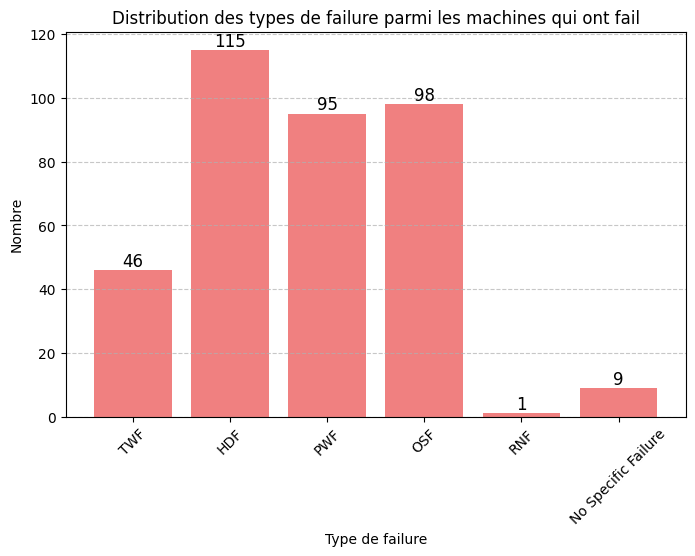

In [29]:
dataset = pd.read_csv("ai4i2020.csv")
failed_machines = dataset[dataset["Machine failure"] == 1]
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_counts = failed_machines[failure_types].sum()
no_specific_failure = (failed_machines[failure_types].sum(axis=1) == 0).sum()

failure_counts["No Specific Failure"] = no_specific_failure

plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color='lightcoral')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             int(bar.get_height()), ha='center', va='bottom', fontsize=12)

plt.xlabel("Type de failure")
plt.ylabel("Nombre")
plt.title("Distribution des types de failure parmi les machines qui ont fail")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


**ANALYSIS QUESTION:** What do you observe compared to the previous question ? What can you conclude?

On pense que la seule donnée RNF est sûrement une erreur dans le dataset, puisque RNF et TWF sont à 1. Cela veut dire que la machine failure est contabilisée 2 fois, en tant que random et en tant que failure définie. Cela est contradictoire.

De plus, les No Specific Failure ne seront pas comptabilisés dans la suite du traitement de données, puisque notre objectif est de prédire les pannes. Donc ces No Specific Failure ne nous seront d'aucune utilité pour entrainer le modèle à prédire les pannes.

D'autre part, nous constatons que TWF, HDF, PWF et OSF sont du même ordre de grandeur. Ainsi il faut en priorité régler la différence de taille de données entre les 9661 No Failure et les Fails, de sorte à avoir un dataset plus homogène.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [30]:
print(dataset.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to use previous results to justify your response.

**Outputs**
Nous voulons prévoir si une machine va fail et son type de failure donc on a les outputs suivants :

- machine failure (0 ou 1)
- le type de failure (TWF, HDF, PWF, OSF, RNF qui sont à 0 ou 1)

**Inputs**
Le model doit utiliser les conditions dans lesquelles est la machine, et ses paramètres pour prédire la failure. Donc les inputs sont :

- Air temperature
- Process temperature
- Rotational speed 
- Torque 
- Tool wear 

On ne prend pas UDI, product ID et Type puisqu'ils ne renseigne aucune donnée utilisable pour prédire la failure. Il serait tout de même intéressant de tester un modèle prenant en compte ces paramètres.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [31]:
dataset['No Failure'] = 1 - dataset["Machine failure"]
#La première classe correspondra à "pas d'erreur"

X = dataset[["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]].to_numpy()
Y = dataset[["No Failure", "TWF", "HDF", "PWF", "OSF"]].to_numpy()
#La première classe correspondra à "pas d'erreur", les autres sont les erreurs possibles sans compter "RNF"

# Division en jeu d'entraînement (80%) et de test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Afficher le nombre d'éléments dans chaque ensemble
print(f"Nombre d'éléments dans X_train : {X_train.shape}")
print(f"Nombre d'éléments dans Y_train : {Y_train.shape}")
print(f"Nombre d'éléments dans X_test : {X_test.shape}")
print(f"Nombre d'éléments dans Y_test : {Y_test.shape}")

Nombre d'éléments dans X_train : (8000, 5)
Nombre d'éléments dans Y_train : (8000, 5)
Nombre d'éléments dans X_test : (2000, 5)
Nombre d'éléments dans Y_test : (2000, 5)


**QUESTION** Code below the model architecture

Nous mettons en place un réseau de neurone MLP.

In [32]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))  # Suppression de la dimension supplémentaire
x = tf.keras.layers.Dense(32, activation='relu')(inputs)  # Plus de neurones dans la première couche cachée
x = tf.keras.layers.Dense(64, activation='relu')(inputs) 
x = tf.keras.layers.Dense(32, activation='relu')(x)  # Ajout d'une deuxième couche cachée
outputs = tf.keras.layers.Dense(Y_train.shape[1], activation='softmax')(x)  # Couche de sortie pour 5 classes
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="improved_mlp_model")

my_mlp_model.summary()
my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "improved_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629 (10.27 KB)

 Trainable params: 2,629 (10.27 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

In [33]:
nb_epochs=20
batch_size=32

training_history = my_mlp_model.fit(X_train,Y_train,
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# Évaluation du modèle sur les données de test
test_loss, test_acc = my_mlp_model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6848 - loss: 97.5473   
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.9573 - loss: 0.3808
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.9575 - loss: 0.3351
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.9569 - loss: 0.3072
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.9585 - loss: 0.3252
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.9573 - loss: 0.2991
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.9550 - loss: 0.4197
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.9560 - loss: 0.2383
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.9544 - loss: 0.3056
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9624 - loss: 0.2348
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.9473 - loss: 0.4579
Epoch 12/20
250/250 ━━━━━━━━━━

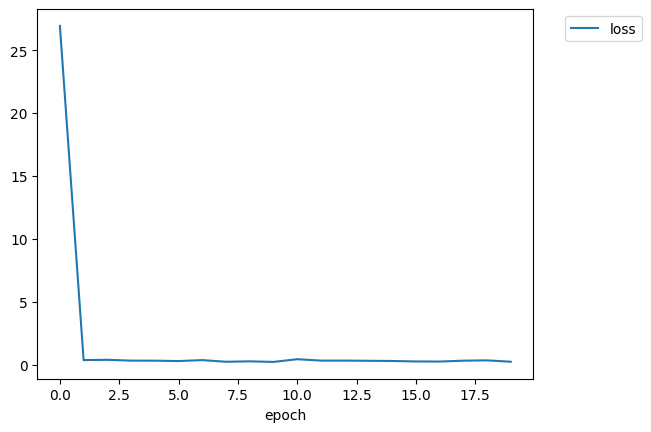

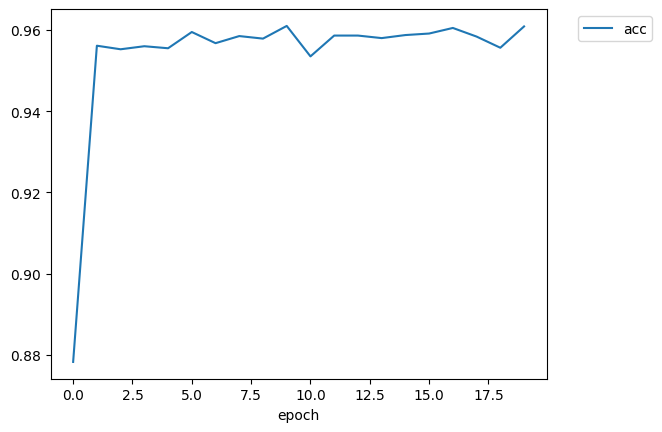

Final Accuracy on test set: 0.9585000276565552


In [34]:
def display_training_curves(training_history):
  # affichage loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  # affichage accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

display_training_curves(training_history)

print("Final Accuracy on test set:", test_acc)


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for classifier my_mlp_model:
              precision    recall  f1-score   support

  No Failure       0.99      0.98      0.98      1941
         TWF       0.00      0.00      0.00        11
         HDF       0.00      0.00      0.00        17
         PWF       0.75      0.17      0.27        18
         OSF       0.19      1.00      0.32        13

   micro avg       0.96      0.96      0.96      2000
   macro avg       0.38      0.43      0.31      2000
weighted avg       0.97      0.96      0.96      2000
 samples avg       0.96      0.96      0.96      2000




C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


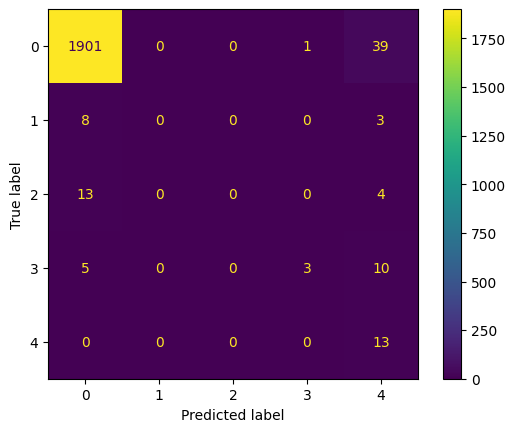

In [35]:
predictions = my_mlp_model.predict(X_test) 
predictions_bin = np.zeros_like(predictions) # initialisation avec des 0
predictions_bin[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1 # 1 au niveau de la classe prédite


Y_test_bin  = np.zeros_like(Y_test) # initialisation avec des 0
Y_test_bin[np.arange(Y_test.shape[0]), np.argmax(Y_test, axis=1)] = 1 # 1 au niveau de la classe réelle

class_names = ["No Failure", "TWF", "HDF", "PWF", "OSF"]

# Affichage du rapport de classification
print(
    f"Classification report for classifier my_mlp_model:\n"
    f"{classification_report(Y_test_bin, predictions_bin, target_names=class_names)}\n"
)

# Affichage de la matrice de confusion
cm = confusion_matrix(Y_test_bin.argmax(axis=1), predictions_bin.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

On voit bien sur la matrice de confusion que le modèle fait des bonnes prédictions pour la classe 0 mais pas pour les autres.
En effet, la classe 0 correspond à "No Failure" et pour rappel, nous avions trouvé les résultats suivants dans la première partie de ce rapport : 
Nombre d'occurrences de chaque état :
| Machine failure | Count |
|----------------|-------|
| 0              | 9661  |
| 1              | 339   |


On voit donc que dans le Dataset complet, 97% des données correspondent à une absence de défaut.

Ainsi, lorsque le modèle apprend il catégorise en permancence dans la classe 0 ce qui fait que l'accuracy est de 97% comme on peut le voir sur les graphiques plus haut lors de l'apprentissage.

Il est donc nécessaire de modifier le dataset pour que les données de la classe 0 soient en proportion similaires à celles des autres classes.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [41]:
# Convertir les étiquettes multilabel en une seule étiquette par échantillon pour utiliser SMOTE
Y_single_label = np.array([np.argmax(row) for row in Y]) # On prend la classe la plus probable

# Afficher la distribution originale des classes
print('Original dataset shape:\n', Counter(Y_single_label))

# Appliquer SMOTE pour équilibrer les classes
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_scaled, Y_single_label)

# Afficher la distribution des classes après rééchantillonnage
print('Resampled dataset shape with SMOTE: \n', Counter(Y_res))

# A commenter si on veut appliquer uniquement SMOTE
# Appliquer RandomUnderSampler pour équilibrer les classes avec un trie aléatoire avec sampling_strategy='auto'
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, Y_res_single_label = rus.fit_resample(X_res, Y_res)

# Afficher la distribution des classes après rééchantillonnage
print('Resampled dataset shape after RandomUnderSampler: \n', Counter(Y_res_single_label))

Y_res_multilabel = np.zeros((Y_res_single_label.size, Y.shape[1])) 
Y_res_multilabel[np.arange(Y_res_single_label.size), Y_res_single_label] = 1 

# Diviser les données rééchantillonnées en ensembles d'entraînement et de test
X_train_SMOTE, X_test_SMOTE, Y_train_SMOTE, Y_test_SMOTE = train_test_split(X_res, Y_res_multilabel, test_size=0.2, random_state=42)

# Afficher le nombre d'éléments dans chaque ensemble
print(f"Nombre d'éléments dans X_train : {X_train_SMOTE.shape}")
print(f"Nombre d'éléments dans Y_train : {Y_train_SMOTE.shape}")
print(f"Nombre d'éléments dans X_test : {X_test_SMOTE.shape}")
print(f"Nombre d'éléments dans Y_test : {Y_test_SMOTE.shape}")

Original dataset shape:
 Counter({np.int64(0): 9670, np.int64(2): 115, np.int64(3): 91, np.int64(4): 78, np.int64(1): 46})
Resampled dataset shape with SMOTE: 
 Counter({np.int64(0): 9670, np.int64(3): 9670, np.int64(1): 9670, np.int64(4): 9670, np.int64(2): 9670})
Resampled dataset shape after RandomUnderSampler: 
 Counter({np.int64(0): 9670, np.int64(1): 9670, np.int64(2): 9670, np.int64(3): 9670, np.int64(4): 9670})
Nombre d'éléments dans X_train : (38680, 5)
Nombre d'éléments dans Y_train : (38680, 5)
Nombre d'éléments dans X_test : (9670, 5)
Nombre d'éléments dans Y_test : (9670, 5)


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

Le test de la méthode RandomUnderSampling seule donnait une accuracy correcte, mais pas assez convaincante. Cela peut s'expliquer par le fait sue nous supprimons une quantité immense de données, et nous nous retrouvons avec un dataset très appauvrit.

Nous avons ensuite testé la méthode SMOTE seule, qui va permettre de générer des échantillons pour les classes en minorité. Ainsi, on enrichira notre dataset au lieu de l'appauvrir comme la technique précédente. Nous avons obtenu des résultats très encourageants avec cette méthode (plus de 90% d'accuracy) ce qui nous a poussé à poursuivre dans cette voie.

On garde le RandomUnderSampling pour trier aléatoirement les données, après le SMOTE. En effet, nous avons observvé que cette étape améliorait légèrement notre accuracy.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [42]:
# Utilisation du modèle de la partie 2, pour comparer
inputs = tf.keras.Input(shape=(X_train_SMOTE.shape[1],))  # Première couche de la taille des données d'entrée (5)
x = tf.keras.layers.Dense(32, activation='relu')(inputs)  # 3 couches cachées
x = tf.keras.layers.Dense(64, activation='relu')(inputs) 
x = tf.keras.layers.Dense(32, activation='relu')(x) 
outputs = tf.keras.layers.Dense(Y_train_SMOTE.shape[1], activation='softmax')(x)  # Couche de sortie pour 5 classes
improved_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="improved_mlp_model")

improved_mlp_model.summary()

# Compilation du modèle
improved_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "improved_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629 (10.27 KB)

 Trainable params: 2,629 (10.27 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5486 - loss: 9.7232
Epoch 2/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7549 - loss: 0.8527
Epoch 3/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7860 - loss: 0.7960
Epoch 4/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8112 - loss: 0.6544
Epoch 5/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8018 - loss: 0.7314
Epoch 6/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8286 - loss: 0.5904
Epoch 7/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8301 - loss: 0.5750
Epoch 8/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8505 - loss: 0.4999
Epoch 9/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8530 - loss: 0.4719
Epoch 10/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8479 - loss: 0.4836
Epoch 11/40
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8647 - loss: 0.4238
Epoch 12/40
1209/1209 ━━━━━━━━

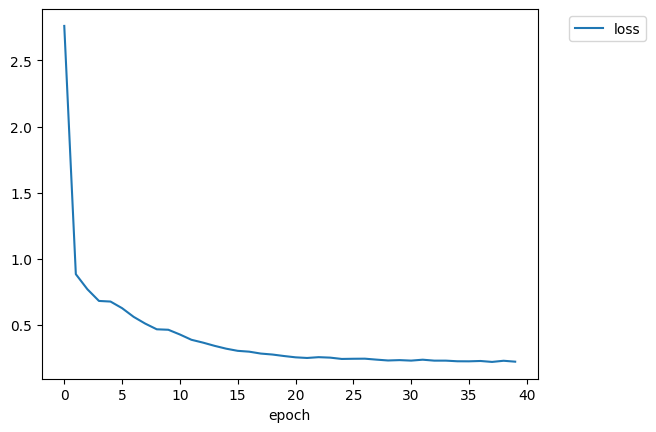

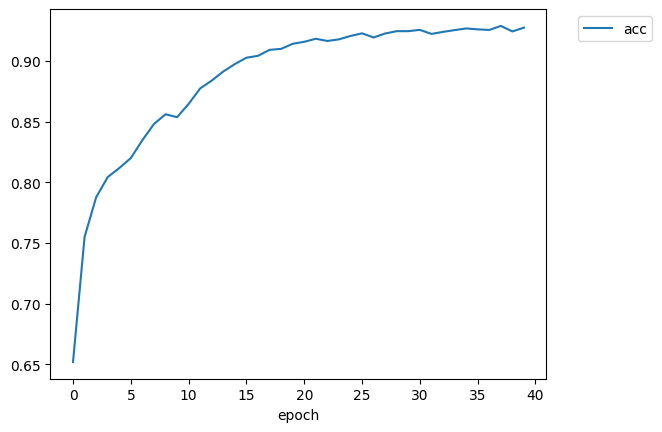

Final Accuracy on test set: 0.946949303150177


In [43]:
nb_epochs=40
batch_size=32

training_history = improved_mlp_model.fit(X_train_SMOTE,Y_train_SMOTE,
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# Évaluation du modèle sur les données de test
test_loss, test_acc = improved_mlp_model.evaluate(X_test_SMOTE, Y_test_SMOTE)
print(f"Test accuracy: {test_acc}")

display_training_curves(training_history)
print("Final Accuracy on test set:", test_acc)

**QUESTION** Plot the confusion matrix and the classification report

303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
Classification report for classifier improved_mlp_model:
              precision    recall  f1-score   support

  No Failure       0.99      0.84      0.91      1967
         TWF       0.94      0.93      0.93      1845
         HDF       0.90      0.97      0.93      1965
         PWF       0.98      1.00      0.99      1959
         OSF       0.93      0.99      0.96      1934

   micro avg       0.95      0.95      0.95      9670
   macro avg       0.95      0.95      0.95      9670
weighted avg       0.95      0.95      0.95      9670
 samples avg       0.95      0.95      0.95      9670




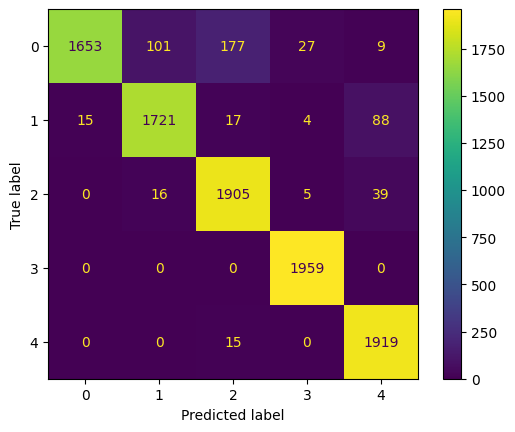

In [44]:
predictions = improved_mlp_model.predict(X_test_SMOTE) 
predictions_bin = np.zeros_like(predictions) 
predictions_bin[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1 # 1 au niveau de la classe prédite

Y_test_bin  = np.zeros_like(Y_test_SMOTE)
Y_test_bin[np.arange(Y_test_SMOTE.shape[0]), np.argmax(Y_test_SMOTE, axis=1)] = 1 # 1 au niveau de la classe réelle

# Affichage du rapport de classification
print(
    f"Classification report for classifier improved_mlp_model:\n"
    f"{classification_report(Y_test_bin, predictions_bin, target_names=class_names)}\n"
)

# Affichage de la matrice de confusion
cm = confusion_matrix(Y_test_bin.argmax(axis=1), predictions_bin.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

On trace maintenant la matrice avec les données réelles préalablement équilibrées (sans le SMOTE).

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification report for classifier improved_mlp_model:
              precision    recall  f1-score   support

  No Failure       0.97      0.85      0.91        46
         TWF       1.00      0.91      0.95        46
         HDF       0.82      1.00      0.90        46
         PWF       0.98      1.00      0.99        46
         OSF       0.98      0.96      0.97        46

    accuracy                           0.94       230
   macro avg       0.95      0.94      0.94       230
weighted avg       0.95      0.94      0.94       230


Confusion matrix after resampling:


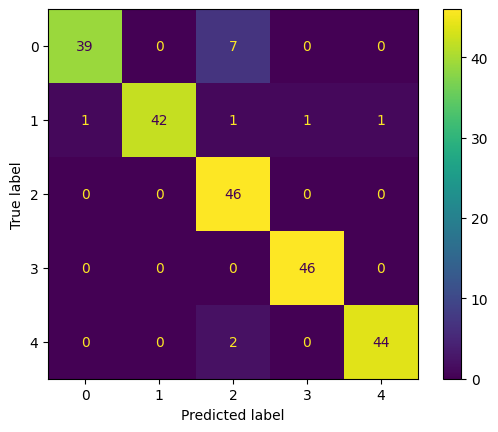

In [45]:
# Feature extraction
X = dataset[["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]].to_numpy()
Y = dataset[["No Failure", "TWF", "HDF", "PWF", "OSF"]].to_numpy()

Y_single_label = np.argmax(Y, axis=1)

# Perform random undersampling
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_res, Y_res_single_label = rus.fit_resample(X, Y_single_label)

# Convert back to multi-label representation
Y_res_multilabel = np.zeros((Y_res_single_label.size, Y.shape[1]))
Y_res_multilabel[np.arange(Y_res_single_label.size), Y_res_single_label] = 1

predictions = improved_mlp_model.predict(X_res)

predictions_bin = np.zeros_like(predictions)
predictions_bin[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1

Y_test_bin = Y_res_multilabel

# Affichage du rapport de classification
print(
    f"Classification report for classifier improved_mlp_model:\n"
    f"{classification_report(Y_test_bin.argmax(axis=1), predictions_bin.argmax(axis=1), target_names=class_names)}\n"
)

# Affichage de la matrice de confusion
print("Confusion matrix after resampling:")
cm = confusion_matrix(Y_test_bin.argmax(axis=1), predictions_bin.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Nous observons que le modèle prédit bien les différentes pannes puisque la majorité des points se situent sur la diagonale. On observe cependant quelques erreurs dans les prédictions.

Mais comme nous avons créé des données via le SMOTE, nous pouvons nous demander si notre dataset est vraiment fiable, puisqu'il est en grande partie synthétisé. Pour se faire, on vérifie que le procédé de SMOTE ne corompt pas le dataset en comparant avec des données qui n'ont pas subis de SMOTE (cf la deuxième matrice).
Nous retrouvons un pourcentage d'erreur d'environ 5% pour les 2 matrices, donc la synthèse des données par le SMOTE ne favorise pas les erreurs.

**Exportation of the model :**

In [ ]:
# Ligne suivante à supprimer pour exporter le modèle
'''improved_mlp_model.save('./saved_models/improved_mlp_model.h5', save_format='h5')

converter = tf.lite.TFLiteConverter.from_keras_model(improved_mlp_model)
tflite_model = converter.convert()
with open('./saved_models/improved_mlp_model.tflite', 'wb') as f:
    f.write(tflite_model)
'''


#Exportation des données
Y_test_single_label_SMOTE = np.array([np.argmax(row) for row in Y_test_SMOTE])

#Les tableaux de données exportées sont ceux avec le SMOTE correspondant aux données avec des classes équilibrées TODO
np.savetxt("./saved_data/X_test.csv", X_test_SMOTE.reshape(X_test_SMOTE.shape[0], -1), delimiter=",", fmt="%.6f")  # On exporte en flottants
np.savetxt("./saved_data/Y_test.csv", Y_test_single_label_SMOTE.reshape(Y_test_single_label_SMOTE.shape[0], -1), delimiter=",", fmt="%d")  # Save as .csv
np.save("./saved_data/X_test.npy", X_test_SMOTE)  # Save as .npy
np.save("./saved_data/Y_test.npy", Y_test_single_label_SMOTE)  # Save as .npy

#On exporte aussi les données réelles équilibrées
np.savetxt("./saved_data/X.csv", X_res.reshape(X_res.shape[0], -1), delimiter=",", fmt="%.6f")  # On exporte en flottants
np.savetxt("./saved_data/Y.csv", Y_res_multilabel.reshape(Y_res_multilabel.shape[0], -1), delimiter=",", fmt="%d")  # Save as .csv
np.save("./saved_data/X.npy", X_res)  # Save as .npy
np.save("./saved_data/Y.npy", X_res)  # Save as .npy



In [47]:
def test_single_input(model, input_data, class_names):
    # Reshape the input data to match the model's expected input shape
    input_data = np.array(input_data).reshape(1, -1)
    
    # Make a prediction
    prediction = model.predict(input_data)
    # Convert the prediction to a binary format
    prediction_bin = np.zeros_like(prediction)
    prediction_bin[np.arange(prediction.shape[0]), np.argmax(prediction, axis=1)] = 1
    print(prediction_bin)

    # Get the predicted class
    predicted_class = class_names[np.argmax(prediction)]
    
    print(f"Input data: {input_data}")
    print(f"Predicted class: {predicted_class}")

# Example input data (replace with actual input data)
index = np.where(Y[:, 1] == 1)[0][5]  # Trouver le premier index où TWF est 1

example_input = X[index]

# Test the model on the example input
test_single_input(improved_mlp_model, example_input, class_names)
print("Expected result :", Y[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0. 1. 0. 0. 0.]]
Input data: [[ 298.4  308.  1416.    38.2  198. ]]
Predicted class: TWF
Expected result : [0 1 0 0 0]
